# Diabetes key indicators

Diabetes is among the most prevalent chronic diseases in the United States, impacting millions of Americans each year and exerting a significant financial burden on the economy. While there is no cure for diabetes, strategies like losing weight, eating healthily, being active, and receiving medical treatments can mitigate the harms of this disease in many patients. Early diagnosis can lead to lifestyle changes and more effective treatment, making predictive models for diabetes risk important tools for public and public health officials.

The "Behavioral Risk Factor Surveillance System" ([BRFSS](https://www.cdc.gov/brfss/data_documentation/index.htm)) is a a cross-sectional telephone survey that is used to collect prevalence data among adult U.S. residents regarding their risk behaviors and preventive health practices that can affect their health status.

The original dataset contains responses from over 400000 individuals and has 330 features. For this project, a csv of the dataset available on Kaggle for the year 2015 was used and it includes 21 features

The selected features are the ones considered as risk factors for type II diabetes, prediabetes and diabetes during pregnancy.

Target
* 0 for no diabetes or only during pregnancy
* 1 for diabetes and prediabetes


The complete pdf survey can be found [here](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf)


## Download data from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [1]:
##create an API token in Kaggle then load the json file to login in kaggle
from google.colab import files

uploaded = files.upload()

In [ ]:
##path to json
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

api = KaggleApi()
api.authenticate()

In [ ]:
api.dataset_download_file('alexteboul/diabetes-health-indicators-dataset','diabetes_binary_health_indicators_BRFSS2015.csv')

import zipfile
#dezippo il file
with zipfile.ZipFile('./diabetes_binary_health_indicators_BRFSS2015.csv.zip', 'r') as f:
  f.extractall('./')

# Modules import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE 
import time

In [ ]:
##start the timer
tic=time.process_time()

Creation of the dataframe

In [ ]:
df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
df.head(20)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,1.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


Feature description (the binary ones correspond to yes/no)

* **Diabetes_binary**: presence od dibates or prediabetes
* **HighBP**: high blood pressure (binary)
* **HighChol**: high cholesterol  (binary)
* **CholCheck**: cholesterol medical examination in the past 5 years  (binary)
* **BMI**: bmi
* **Smoker**: yes if the person smoked at least 100 cigarettes in a life time (binary)
* **Stroke**: stroke  (binary)
* **HeartDiseaseorAttack**:  (binary)
* **PhysActivity**: any physical activity in the past 30 days (binary)
* **Fruits**: any fruits during the day (binary)
* **Veggies**: any vegetables during the day  (binary)
* **HvyAlcoholConsump**: person that drinks more than 14 alcoholic beverage in a week (man) or 7 (woman) (binary)
* **AnyHealthcare**: health insurance (binary)
* **NoDocbcCost**: give up a medical examination because of cost
* **GenHlth**: health conditions (1=excellent, 5=poor)
* **MentHlth**: in the past 30 days how many days the person mental health was not good?
* **PhysHlth**: in the past 30 days how many days the person physical health was not good?
* **DiffWalk**: difficulty to walk (binary)
* **Sex**: woman 0, man 1
* **Age**:  1:18-24 years, 2: 25-29, 3: 30-34,...,12: 75-79, 13: 80 or greater
* **Education**: level of education, 1: no school, 2: primary school, 3: high school (not competed), 4: high school, 5: college, 6: gradutated
* **Income**: income in 8 categories, 1: less than 10k dollars, 2: 10-15k, 3: 15-20k, 4: 20-25k, 5: 25-35k, 6: 25-50k, 7: 50-75k, 8: above 75k


## Features exploration

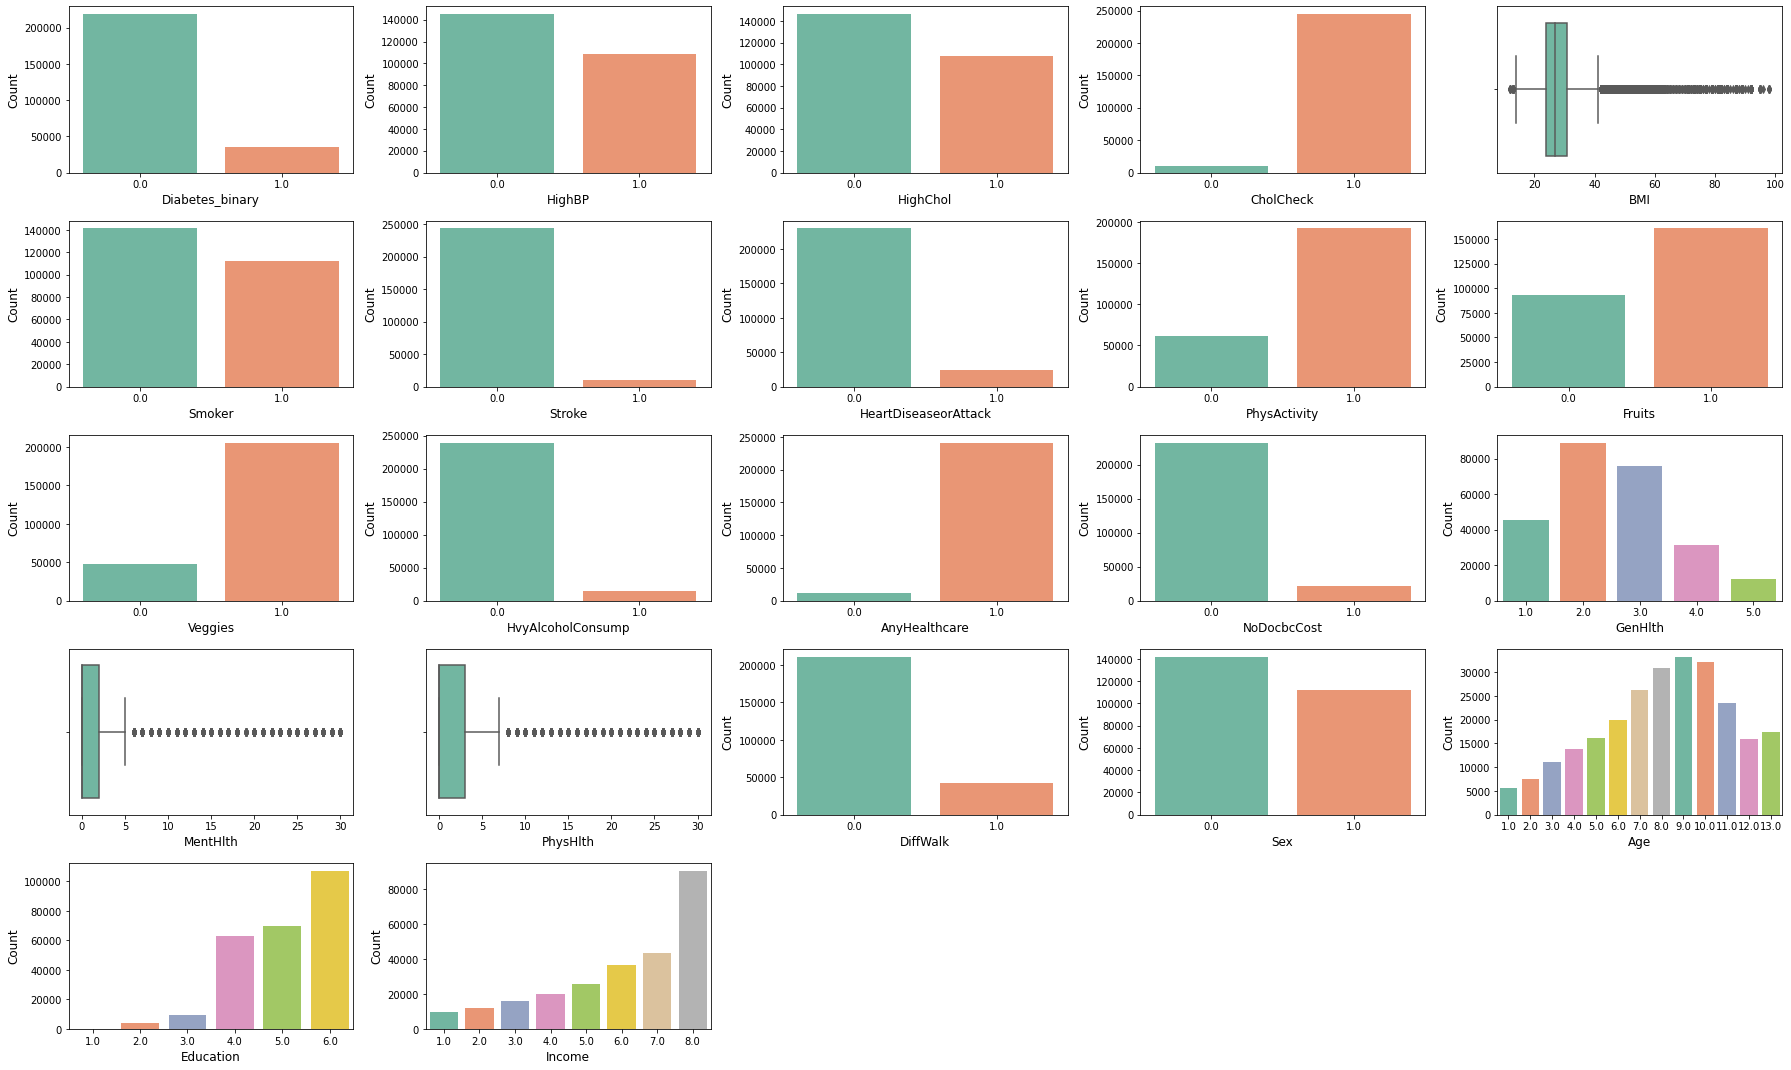

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(25, 15))
ax =ax.flatten()

columns_boxplot = ['BMI','MentHlth','PhysHlth'] 
for i, col in enumerate(df.columns):
  if col in columns_boxplot:
    chart = sns.boxplot(x=df[col],ax =ax[i],palette="Set2")
    chart.set_xlabel(col, fontsize=12 )
    chart.set_ylabel('',fontsize=12 )
    chart.tick_params(labelsize=10)
  else:
    chart = sns.countplot(x= df[col], ax =ax[i],palette="Set2")
    chart.set_xlabel(col, fontsize=12 )
    chart.set_ylabel('Count',fontsize=12 )
    chart.tick_params(labelsize=10)

for ax in ax[22:]:
  ax.remove()
fig.tight_layout()

Dataset is unblanced, 86% of values is 0 (no diabetes)

In [ ]:
print(f'classe 0: {(df.Diabetes_binary[df.Diabetes_binary==0].value_counts()/df.Diabetes_binary.size)[0]}', 
      f'classe 1: {(df.Diabetes_binary[df.Diabetes_binary==1].value_counts()/df.Diabetes_binary.size)[1]}')


classe 0: 0.8606669820245979 classe 1: 0.13933301797540207


Check of target variables vs the other columns

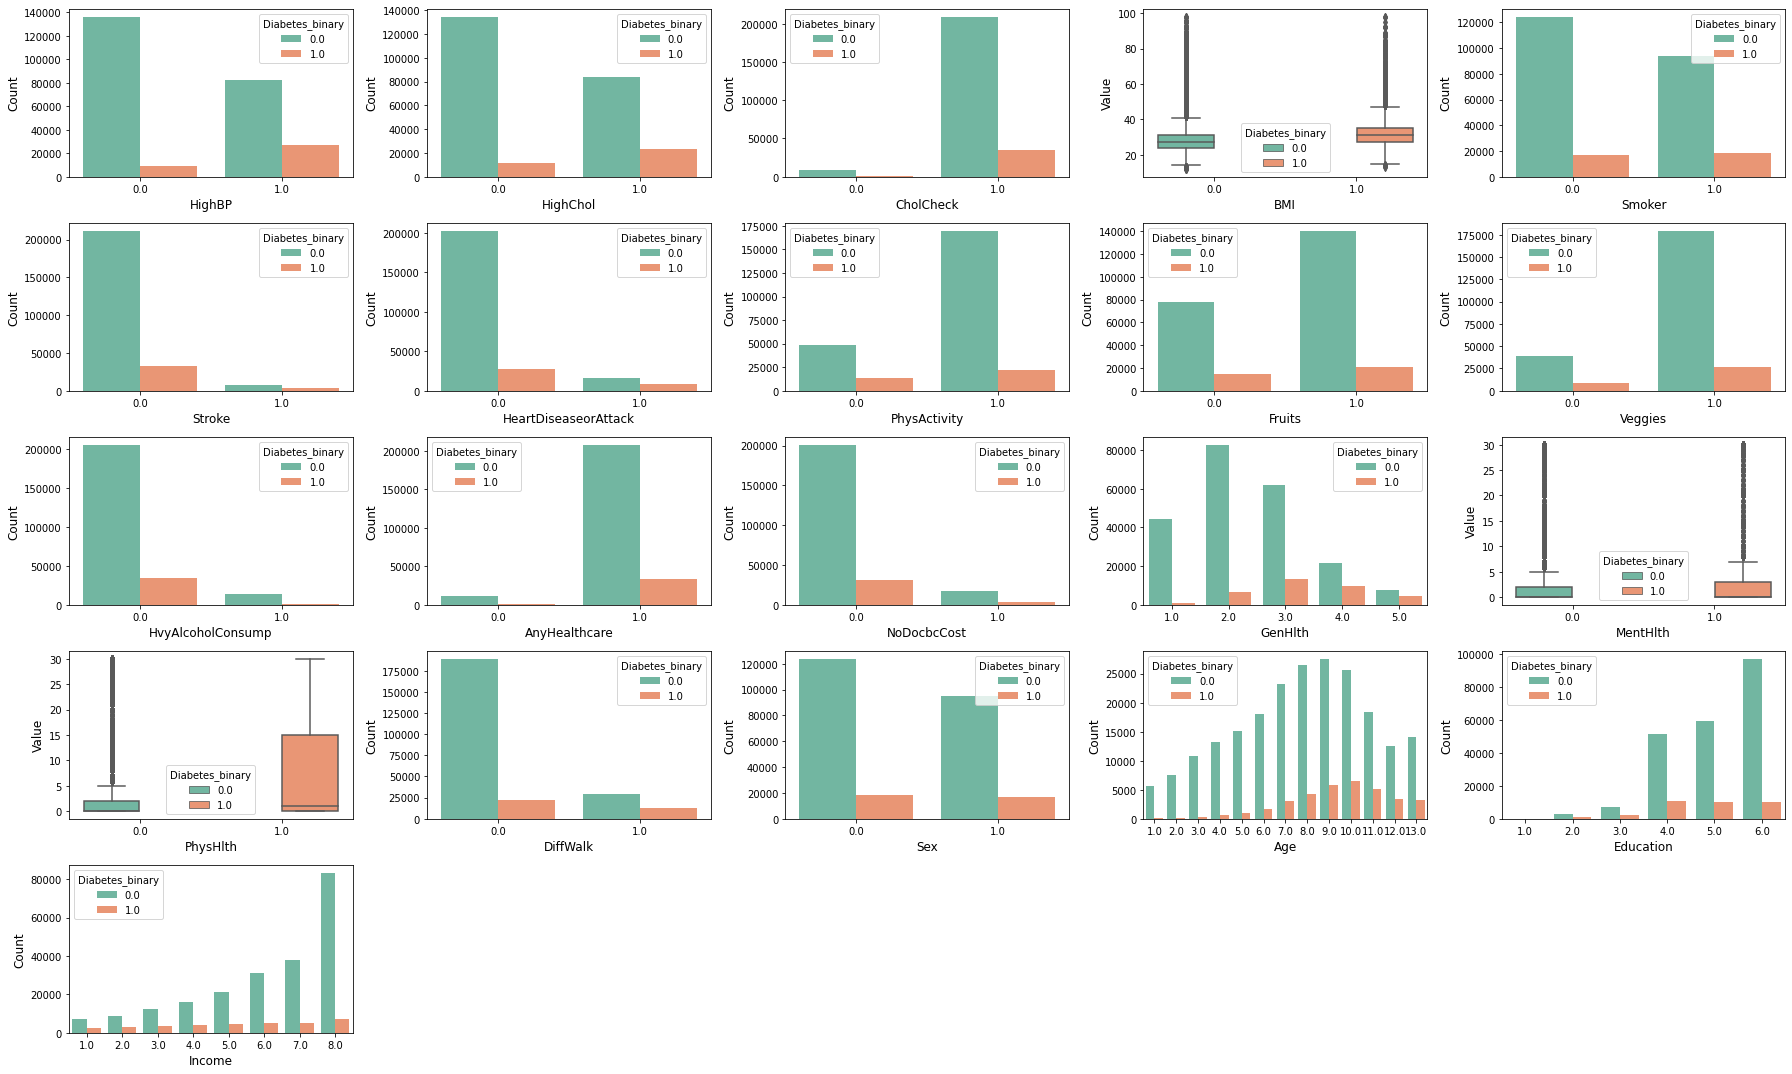

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(25, 15))
ax =ax.flatten()

columns_boxplot = ['BMI','MentHlth','PhysHlth'] 
for i, col in enumerate(df.columns[1:]):
  if col in columns_boxplot:
    chart = sns.boxplot(y=df[col], x='Diabetes_binary',ax =ax[i],palette="Set2", data=df,hue='Diabetes_binary')
    chart.set_xlabel(col, fontsize=12 )
    chart.set_ylabel('Value',fontsize=12 )
    chart.tick_params(labelsize=10)
  else:
    chart = sns.countplot(x= df[col], ax =ax[i],palette="Set2",data=df,hue='Diabetes_binary')
    chart.set_xlabel(col, fontsize=12 )
    chart.set_ylabel('Count',fontsize=12 )
    chart.tick_params(labelsize=10)

for ax in ax[21:]:
  ax.remove()
fig.tight_layout()

Diabtes is more common if
* the peson has high blood pressure /high cholesterol/stroke
* the health condition is poor or there is difficulty to walk
* the income is in the bottom range (low)


# Preprocessing

## Train and Test split

In [ ]:
X = df.drop(['Diabetes_binary'], axis=1)
y = df[['Diabetes_binary']]

We use stratify to mantain the occurrence of diabetes in train and validation

In [ ]:
X_train, X_val_0, y_train, y_val_0 = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_val_0, y_val_0, test_size=0.15, random_state=101, stratify=y_val_0)

In [ ]:
X_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
45308,1.0,1.0,1.0,27.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,4.0,1.0,1.0,11.0,5.0,6.0
184820,0.0,1.0,1.0,27.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,6.0,8.0
122151,1.0,1.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
133070,0.0,1.0,1.0,26.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,11.0,5.0,8.0
239487,1.0,1.0,1.0,29.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,14.0,1.0,0.0,11.0,4.0,7.0


In [ ]:
X_val.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
238060,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0
94160,0.0,0.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,5.0,7.0
49025,0.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0
177925,1.0,1.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,11.0,6.0,8.0
192244,1.0,0.0,1.0,21.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,5.0,0.0,5.0,1.0,1.0,13.0,5.0,5.0


In [ ]:
X_test.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
139689,0.0,0.0,1.0,46.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,5.0,5.0,6.0
135727,0.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,20.0,1.0,0.0,13.0,3.0,8.0
150855,1.0,1.0,1.0,33.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,13.0,5.0,4.0
62793,1.0,1.0,1.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,2.0,0.0,0.0,8.0,3.0,3.0
181747,0.0,0.0,1.0,36.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,10.0,5.0,7.0


## Encoding of categorical variables

In [ ]:
X_columns= X_train.columns
X_not_to_encode = ['BMI','MentHlth','PhysHlth'] 

X_to_encode = list(set(X_columns) - set(X_not_to_encode))

Fit the LabelEncoder on the training set

In [ ]:
label_encoder =LabelEncoder()
label_encoder.fit(X_train[X_to_encode].values.flatten())

LabelEncoder()

In [ ]:
X_train[X_to_encode] = X_train[X_to_encode].apply(label_encoder.transform)
X_val[X_to_encode] = X_val[X_to_encode].apply(label_encoder.transform)
X_test[X_to_encode] = X_test[X_to_encode].apply(label_encoder.transform)

In [ ]:
X_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
45308,1,1,1,27.0,1,0,1,1,1,1,0,1,0,3,0.0,4.0,1,1,11,5,6
184820,0,1,1,27.0,0,0,0,1,0,1,0,1,0,3,0.0,0.0,0,1,7,6,8
122151,1,1,1,31.0,1,0,0,1,1,1,0,1,0,3,0.0,0.0,0,1,12,6,8
133070,0,1,1,26.0,0,0,1,1,0,0,0,1,0,2,0.0,0.0,0,1,11,5,8
239487,1,1,1,29.0,0,0,0,0,0,1,0,1,0,4,0.0,14.0,1,0,11,4,7


## Scaling

Scaling of the numerical variables with MinMax Scaler

In [ ]:
scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

MinMaxScaler()

In [ ]:
X_train=pd.DataFrame(scaler_x.transform(X_train), index = X_train.index, columns = X_train.columns) 
X_test=pd.DataFrame(scaler_x.transform(X_test), index = X_test.index, columns = X_test.columns)
X_val=pd.DataFrame(scaler_x.transform(X_val), index = X_val.index, columns = X_val.columns)

In [ ]:
X_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
45308,1.0,1.0,1.0,0.174419,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.133333,1.0,1.0,0.833333,0.8,0.714286
184820,0.0,1.0,1.0,0.174419,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,1.0,1.000000
122151,1.0,1.0,1.0,0.220930,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.000000,0.0,1.0,0.916667,1.0,1.000000
133070,0.0,1.0,1.0,0.162791,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.25,0.0,0.000000,0.0,1.0,0.833333,0.8,1.000000
239487,1.0,1.0,1.0,0.197674,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.75,0.0,0.466667,1.0,0.0,0.833333,0.6,0.857143


In [ ]:
X_test.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
139689,0.0,0.0,1.0,0.395349,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.50,0.0,0.033333,0.0,1.0,0.333333,0.8,0.714286
135727,0.0,0.0,1.0,0.348837,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.75,0.0,0.666667,1.0,0.0,1.000000,0.4,1.000000
150855,1.0,1.0,1.0,0.244186,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.50,0.0,0.033333,0.0,0.0,1.000000,0.8,0.428571
62793,1.0,1.0,1.0,0.267442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75,0.0,0.066667,0.0,0.0,0.583333,0.4,0.285714
181747,0.0,0.0,1.0,0.279070,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.50,0.0,0.000000,0.0,0.0,0.750000,0.8,0.857143


In [ ]:
X_val.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
238060,0.0,0.0,1.0,0.232558,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.00,0.0,0.000000,0.0,1.0,0.583333,1.0,1.000000
94160,0.0,0.0,1.0,0.139535,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.25,0.0,0.000000,1.0,1.0,0.750000,0.8,0.857143
49025,0.0,0.0,1.0,0.151163,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.500000,1.0,1.000000
177925,1.0,1.0,1.0,0.162791,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.50,0.0,0.000000,0.0,0.0,0.833333,1.0,1.000000
192244,1.0,0.0,1.0,0.104651,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.00,0.0,0.166667,1.0,1.0,1.000000,0.8,0.571429


## Balancing the training set

We will try to train the neural network with both the training set balanced and unbalanced

We create a new training set where we over-sample the value=1 for the Diabetes_binary target

In [ ]:
print(f'classe 0: {y_train.Diabetes_binary[y_train.Diabetes_binary==0].value_counts()[0]}', 
      f'classe 1: {y_train.Diabetes_binary[y_train.Diabetes_binary==1].value_counts()[1]}')

classe 0: 174667 classe 1: 28277


In [ ]:
strategy = {0: len(y_train.Diabetes_binary[y_train.Diabetes_binary==0]), 
            1: 4*len(y_train.Diabetes_binary[y_train.Diabetes_binary==1])}


In [ ]:
oversample = SMOTE(sampling_strategy=strategy,random_state=101)

In [ ]:
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)

Now class 0 represents 61%, classe 1  39% (before 86%, 14%)

In [ ]:
print(f'classe 0: {y_train_oversampled.Diabetes_binary[y_train_oversampled.Diabetes_binary==0].value_counts()[0]}', 
      f'classe 1: {y_train_oversampled.Diabetes_binary[y_train_oversampled.Diabetes_binary==1].value_counts()[1]}')

classe 0: 174667 classe 1: 113108


In [ ]:
strategy[1]/sum(strategy.values())

0.39304317609243333

## Array for target and features

In [ ]:
train_labels=np.array(y_train)
train_oversampled_labels=np.array(y_train_oversampled)
test_labels=np.array(y_test)
val_labels=np.array(y_val)

print(f'train_labels: {len(train_labels)}, train_oversampled_labels: {len(train_oversampled_labels)}, test_labels: {len(test_labels)}, val_labels: {len(val_labels)}')

train_labels: 202944, train_oversampled_labels: 287775, test_labels: 7611, val_labels: 43125


In [ ]:
train_features = np.array(X_train)
train_oversampled_features = np.array(X_train_oversampled)
test_features = np.array(X_test)
val_features=np.array(X_val)


# Building the network

Loss fucntion is the BinaryCrossEntropy

In [ ]:
def MyModel(n_feature, metrics_info,output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)

  inputs = keras.layers.Input(shape=(n_feature,))
  hidden1 = keras.layers.Dense(32, activation="relu",
                               kernel_regularizer=keras.regularizers.l2(1e-5))(inputs)
  drop1 = keras.layers.Dropout(0.2)(hidden1)
  hidden2 = keras.layers.Dense(64, activation="relu",
                              kernel_regularizer=keras.regularizers.l2(1e-5))(drop1)
  drop2 = keras.layers.Dropout(0.4)(hidden2)
  out = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)(drop2)
  model = keras.Model(inputs=inputs, outputs=out)
  
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-4,
      decay_steps=10000,
      decay_rate=0.9)

  model.compile(
      optimizer=keras.optimizers.Adamax(learning_rate=lr_schedule),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics_info)

  return model


Metrics that will be used for the validation

In [ ]:
metrics_list = [
      keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

EPOCHS = 80
BATCH_SIZE = 200

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    mode='max',
    patience=5,
    restore_best_weights=True)

Some plots we will used later

In [ ]:
#confronto metriche
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  fig, ax = plt.subplots(2,2, figsize=(15, 15))
  ax =ax.flatten()
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    ax[n].plot(history.epoch, history.history[metric], color='royalblue', label='Train')
    ax[n].plot(history.epoch, history.history['val_'+metric],
             color='royalblue', linestyle="--", label='Val')
    ax[n].set_xlabel('Epoch')
    ax[n].set_title(name)
    ax[n].legend()

In [ ]:
# curva roc
def plot_roc(name, labels, predictions, y_min=-0.5, x_max=100, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.ylim([y_min,100])
  plt.xlim([0,x_max])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
#confusion matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels,predictions )
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


## Training of the unbalanced training set

In [ ]:
model_unbalanced = MyModel(X_train.shape[-1],metrics_list,output_bias=-1.8)
model_unbalanced.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                704       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable p

In [ ]:
history_unbalanced =  model_unbalanced.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_features, val_labels),callbacks=[early_stopping])


Epoch 1/80
1015/1015 [==============================] - 5s 3ms/step - loss: 0.3926 - binary_accuracy: 0.8606 - tp: 17.0000 - fp: 30.0000 - tn: 174637.0000 - fn: 28260.0000 - precision: 0.3617 - recall: 6.0120e-04 - auc: 0.6212 - prc: 0.2156 - val_loss: 0.3707 - val_binary_accuracy: 0.8607 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 37116.0000 - val_fn: 6009.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7481 - val_prc: 0.3169
Epoch 2/80
1015/1015 [==============================] - 2s 2ms/step - loss: 0.3698 - binary_accuracy: 0.8602 - tp: 418.0000 - fp: 510.0000 - tn: 174157.0000 - fn: 27859.0000 - precision: 0.4504 - recall: 0.0148 - auc: 0.7179 - prc: 0.2872 - val_loss: 0.3517 - val_binary_accuracy: 0.8606 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 37114.0000 - val_fn: 6008.0000 - val_precision: 0.3333 - val_recall: 1.6642e-04 - val_auc: 0.7739 - val_prc: 0.3405
Epoch 3/80
1015/1015 [==============================] - 2s 2ms/step - loss: 0.3571 - binar

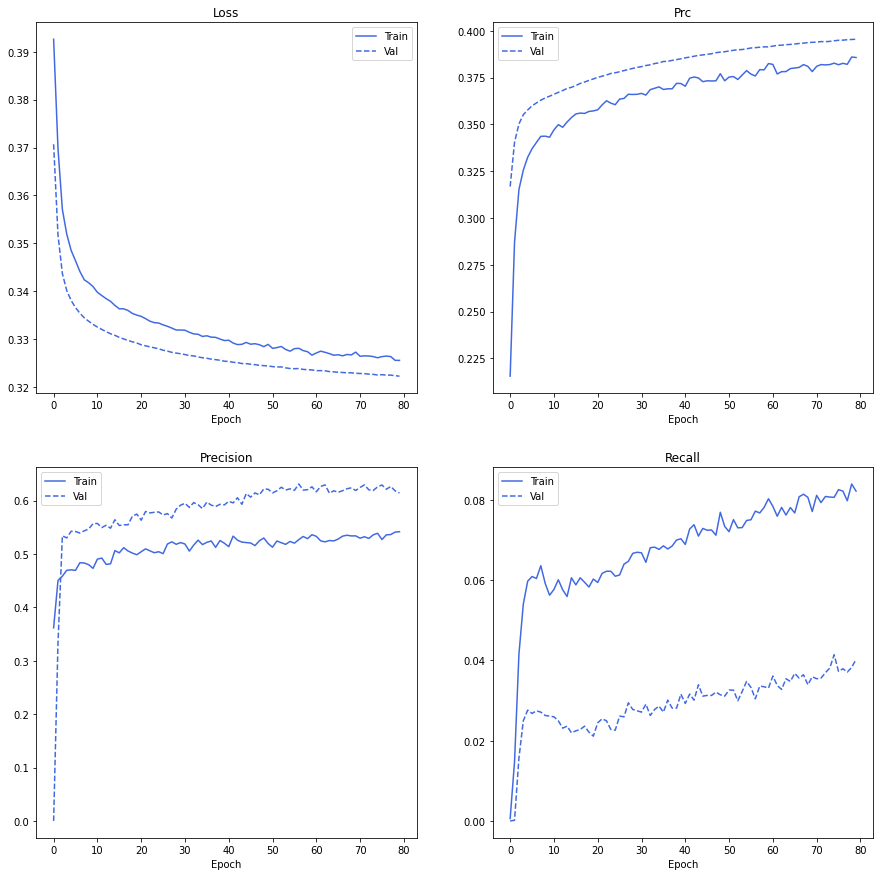

In [ ]:
plot_metrics(history_unbalanced)


In [ ]:
test_predictions = model_unbalanced.predict(test_features, batch_size=BATCH_SIZE)
train_predictions = model_unbalanced.predict(train_features, batch_size=BATCH_SIZE)

When valus is greater than 0.5 then 1, otherwise 0

In [ ]:
test_predictions=np.where(test_predictions >= 0.5, 1,0)
train_predictions=np.where(train_predictions >= 0.5, 1,0)

In [ ]:
print(sklearn.metrics.confusion_matrix(test_labels, test_predictions))

[[6527   24]
 [1014   46]]


Confusion Matrix

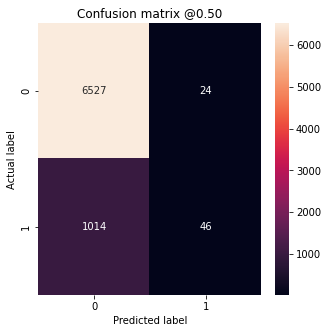

In [ ]:
plot_cm(test_labels, test_predictions)

In [ ]:
test_results = model_unbalanced.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_unbalanced.metrics_names, test_results):
  print(name, ': ', value)
print()


loss :  0.32375025749206543
binary_accuracy :  0.8636184334754944
tp :  46.0
fp :  24.0
tn :  6527.0
fn :  1014.0
precision :  0.6571428775787354
recall :  0.043396227061748505
auc :  0.8138353824615479
prc :  0.40565288066864014



## Training of the balanced training set

In [ ]:
model_balanced = MyModel(X_train_oversampled.shape[-1],metrics_list,output_bias=-0.2)
model_balanced.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_9 (Dense)             (None, 32)                704       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable p

In [ ]:
history_balanced =  model_balanced.fit(train_oversampled_features, train_oversampled_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_features, val_labels),callbacks=[early_stopping])

Epoch 1/80
1439/1439 [==============================] - 6s 3ms/step - loss: 0.6395 - binary_accuracy: 0.6429 - tp: 38714.0000 - fp: 30015.0000 - tn: 151203.0000 - fn: 75454.0000 - precision: 0.5633 - recall: 0.3391 - auc: 0.6557 - prc: 0.5348 - val_loss: 0.5080 - val_binary_accuracy: 0.7878 - val_tp: 3065.0000 - val_fp: 6209.0000 - val_tn: 30907.0000 - val_fn: 2944.0000 - val_precision: 0.3305 - val_recall: 0.5101 - val_auc: 0.7685 - val_prc: 0.3375
Epoch 2/80
1439/1439 [==============================] - 3s 2ms/step - loss: 0.5807 - binary_accuracy: 0.6962 - tp: 59543.0000 - fp: 33859.0000 - tn: 140808.0000 - fn: 53565.0000 - precision: 0.6375 - recall: 0.5264 - auc: 0.7469 - prc: 0.6311 - val_loss: 0.4834 - val_binary_accuracy: 0.7615 - val_tp: 3795.0000 - val_fp: 8070.0000 - val_tn: 29046.0000 - val_fn: 2214.0000 - val_precision: 0.3198 - val_recall: 0.6316 - val_auc: 0.7856 - val_prc: 0.3546
Epoch 3/80
1439/1439 [==============================] - 3s 2ms/step - loss: 0.5600 - binary_

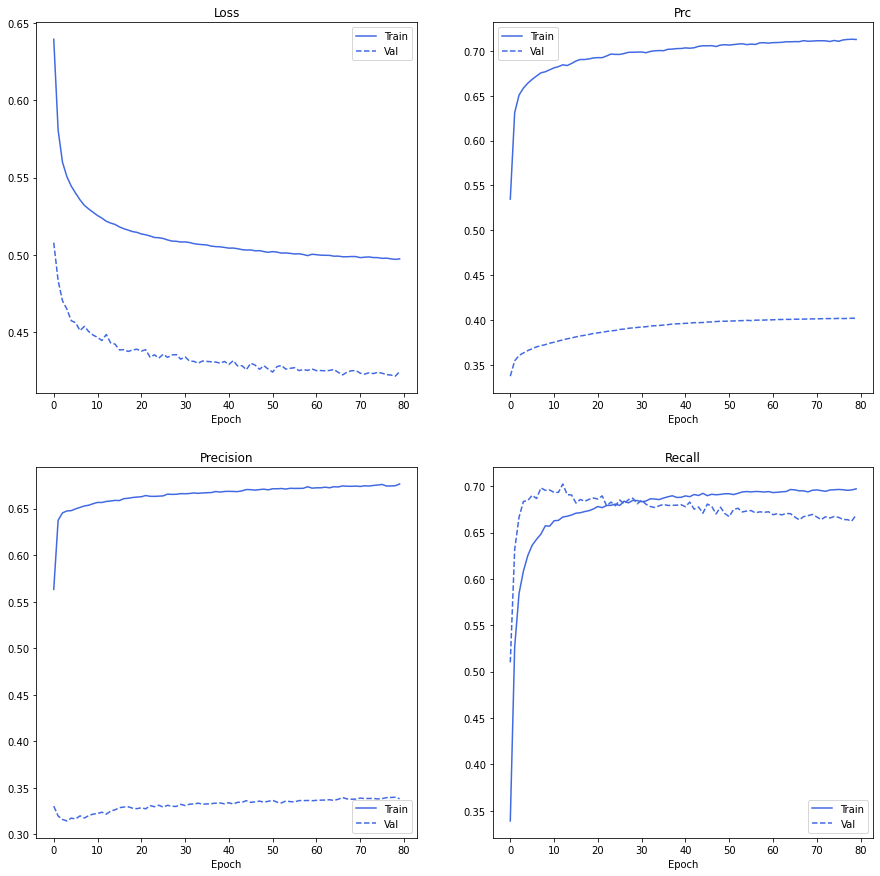

In [ ]:
plot_metrics(history_balanced)

In [ ]:
test_predictions_bal = model_balanced.predict(test_features, batch_size=BATCH_SIZE)
train_predictions_bal  = model_balanced.predict(train_oversampled_features, batch_size=BATCH_SIZE)

In [ ]:
test_predictions_bal=np.where(test_predictions_bal >= 0.5, 1,0)
train_predictions_bal=np.where(train_predictions_bal >= 0.5, 1,0)

In [ ]:
print(sklearn.metrics.confusion_matrix(test_labels, test_predictions_bal))

[[5190 1361]
 [ 344  716]]


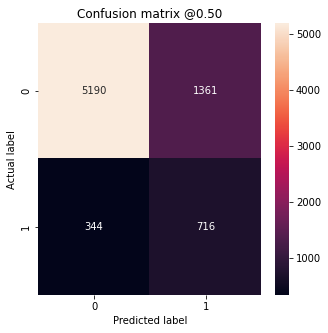

In [ ]:
plot_cm(test_labels,test_predictions_bal)

In [ ]:
test_results_bal = model_balanced.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_balanced.metrics_names, test_results_bal):
  print(name, ': ', value)
print()


loss :  0.4223143458366394
binary_accuracy :  0.775982141494751
tp :  716.0
fp :  1361.0
tn :  5190.0
fn :  344.0
precision :  0.3447279632091522
recall :  0.6754717230796814
auc :  0.8205032348632812
prc :  0.41706377267837524



## Comparasion through the ROC curve

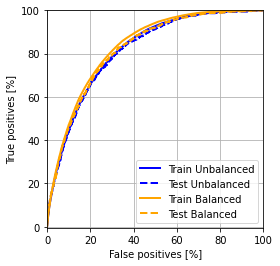

In [ ]:
plot_roc("Train Unbalanced", train_labels, model_unbalanced.predict(train_features, batch_size=BATCH_SIZE), color='blue')
plot_roc("Test Unbalanced", test_labels, model_unbalanced.predict(test_features, batch_size=BATCH_SIZE), color='blue', linestyle='--')

plot_roc("Train Balanced", train_oversampled_labels, model_balanced.predict(train_oversampled_features, batch_size=BATCH_SIZE), color='orange')
plot_roc("Test Balanced", test_labels, model_balanced.predict(test_features, batch_size=BATCH_SIZE), color='orange', linestyle='--')
plt.legend(loc='lower right')


Zoom

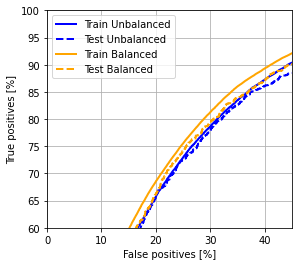

In [ ]:
plot_roc("Train Unbalanced", train_labels, model_unbalanced.predict(train_features, batch_size=BATCH_SIZE), color='blue', y_min=60, x_max=45)
plot_roc("Test Unbalanced", test_labels, model_unbalanced.predict(test_features, batch_size=BATCH_SIZE), color='blue', linestyle='--', y_min=60, x_max=45)

plot_roc("Train Balanced", train_oversampled_labels, model_balanced.predict(train_oversampled_features, batch_size=BATCH_SIZE), color='orange', y_min=60, x_max=45)
plot_roc("Test Balanced", test_labels, model_balanced.predict(test_features, batch_size=BATCH_SIZE), color='orange', linestyle='--', y_min=60, x_max=45)
plt.legend(loc='upper left')

In [ ]:
toc=time.process_time()

In [ ]:
toc-tic

633.411329308